# PA1 - Depth from Focus
---
- 20204102 Juhyeon Nam (AI Graduate School)

In [1]:
import os
DATASET_dir = os.path.join(os.getcwd(),'dataset')
DATASET_dir

'/home/njh/Desktop/CV2020/PA1/dataset'

In [2]:
import cv2
cv2.__version__

'3.4.9'

## TASK 1: Image Alignment (3pts)
---

1. Pick two adjucent sequencial images
2. Find correspondence between them by using Image Aligment Toolbox
3. Plot error map of before and after the alignment

Since I use python not Matlab, I rather used python library than Image Alignment Toolbox to align images. I will specify which libary and references I used to produce the resulted image.

In [3]:
from __future__ import print_function
import numpy as np
import cv2
import matplotlib.pyplot as plt

# Implemented Function
def ErrorMap(gray1, gray2):
    error = cv2.subtract(gray1, gray2)
    return error
    
    
# Code from https://www.learnopencv.com/image-alignment-feature-based-using-opencv-c-python/
# I used python library below not Matlab IAT

MAX_FEATURES = 500
GOOD_MATCH_PERCENT = 0.3

def alignImages(im1, im2):

    # Convert images to grayscale
    im1Gray = cv2.cvtColor(im1, cv2.COLOR_BGR2GRAY)
    im2Gray = cv2.cvtColor(im2, cv2.COLOR_BGR2GRAY)

    # Detect ORB features and compute descriptors.
    orb = cv2.ORB_create(MAX_FEATURES)
    keypoints1, descriptors1 = orb.detectAndCompute(im1Gray, None)
    keypoints2, descriptors2 = orb.detectAndCompute(im2Gray, None)

    # Match features.
    matcher = cv2.DescriptorMatcher_create(cv2.DESCRIPTOR_MATCHER_BRUTEFORCE_HAMMING)
    matches = matcher.match(descriptors1, descriptors2, None)

    # Sort matches by score
    matches.sort(key=lambda x: x.distance, reverse=False)

    # Remove not so good matches
    numGoodMatches = int(len(matches) * GOOD_MATCH_PERCENT)
    matches = matches[:numGoodMatches]

    # Draw top matches
    imMatches = cv2.drawMatches(im1, keypoints1, im2, keypoints2, matches, None)
    cv2.imwrite("matches.jpg", imMatches)

    # Extract location of good matches
    points1 = np.zeros((len(matches), 2), dtype=np.float32)
    points2 = np.zeros((len(matches), 2), dtype=np.float32)

    for i, match in enumerate(matches):
        points1[i, :] = keypoints1[match.queryIdx].pt
        points2[i, :] = keypoints2[match.trainIdx].pt

    # Find homography
    h, mask = cv2.findHomography(points1, points2, cv2.RANSAC)

    # Use homography
    height, width, channels = im2.shape
    
    if h is not None:
        im1Reg = cv2.warpPerspective(im1, h, (width, height))
    else:
        im1Reg = im1

    return im1Reg, h

1. Pick two adjucent sequential images in boxes dataset

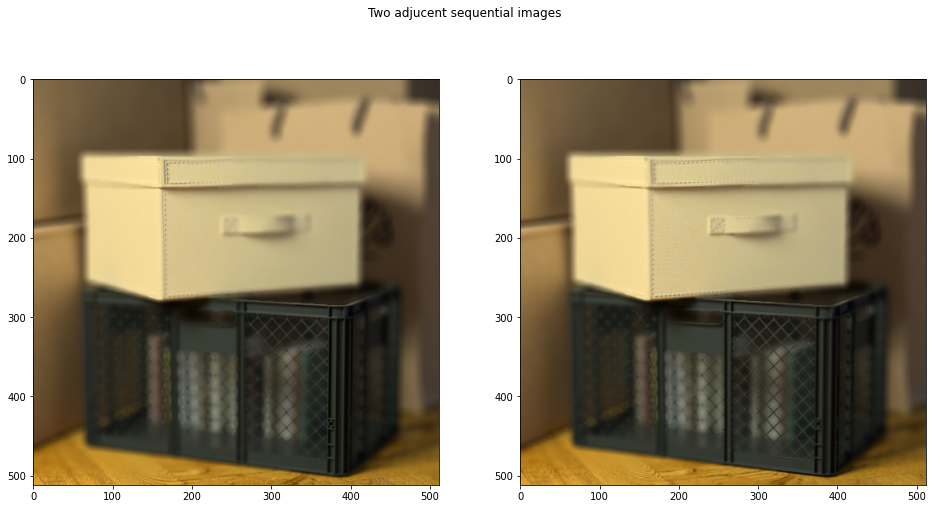

In [4]:
img1 = cv2.imread(os.path.join(DATASET_dir, 'boxes/02.png'), cv2.IMREAD_COLOR)
img2 = cv2.imread(os.path.join(DATASET_dir, 'boxes/03.png'), cv2.IMREAD_COLOR)

gray1 = cv2.cvtColor(img1, cv2.COLOR_BGR2GRAY)
gray2 = cv2.cvtColor(img2, cv2.COLOR_BGR2GRAY)


fig = plt.figure(figsize=(16,8))
fig.suptitle('Two adjucent sequential images')
imgs = [img1, img2]
for i, img in enumerate(imgs):
    fig.add_subplot(1,len(imgs),i+1)
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))

2. Find correspondence between them by using Image Alignment Toolbox

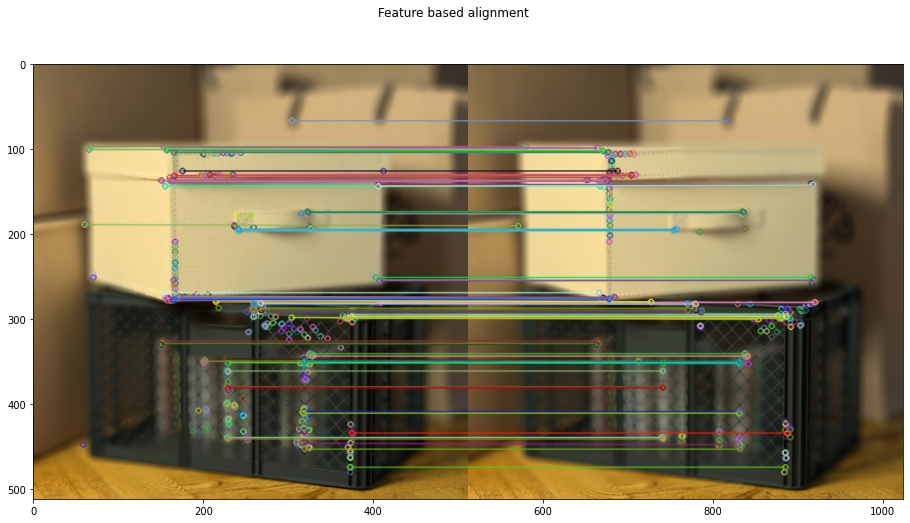

In [5]:
img2Aligned, homography = alignImages(img2, img1)

matches_img = cv2.imread(os.path.join(os.getcwd(), 'matches.jpg'))
plt.figure(figsize=(16,8))
plt.suptitle('Feature based alignment')
plt.imshow(cv2.cvtColor(matches_img, cv2.COLOR_BGR2RGB))

3. Plot error map of before and after alignment

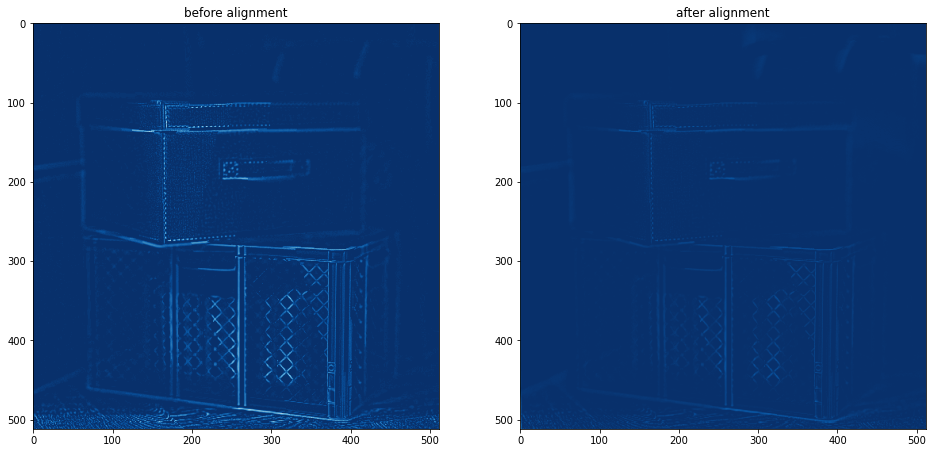

In [6]:
gray_img2Aligned = cv2.cvtColor(img2Aligned, cv2.COLOR_BGR2GRAY)

fig, axs = plt.subplots(1,2, figsize=(16,8))

axs[0].imshow(ErrorMap(gray1, gray2), cmap='Blues_r')
axs[0].set_title("before alignment")

axs[1].imshow(ErrorMap(gray1, gray_img2Aligned), cmap='Blues_r')
axs[1].set_title("after alignment")
plt.show()

Finally, let's align all images in dataset `boxes` and `cotton`

In [7]:
ALIGNED_DATASET_dir = os.path.join(os.getcwd(), "aligned_dataset")

for dt_name in ['boxes','cotton']:
    
    # add first frame of the original dataset to the aligned dataset
    first_frame = cv2.imread(os.path.join(DATASET_dir, dt_name, '01.png'))
    cv2.imwrite(os.path.join(ALIGNED_DATASET_dir, dt_name, '01.png'), first_frame)
    
    for i in range(1, 30):
        aligned1_f = os.path.join(ALIGNED_DATASET_dir, dt_name, "{:02d}.png".format(i))
        img2_f = os.path.join(DATASET_dir, dt_name, "{:02d}.png".format(i+1))
        aligned2_f = os.path.join(ALIGNED_DATASET_dir, dt_name, "{:02d}.png".format(i+1))
        
        img1 = cv2.imread(aligned1_f)
        img2 = cv2.imread(img2_f)
        
        aligned2, h = alignImages(img2, img1)
        
        cv2.imwrite(aligned2_f, aligned2)
        

## Task 2: Initial Depth from Focus Measure (6pts)
---
1. Implement focus measure
2. Make cost volume by applying focus measure to images in dataset


Let's first implement focus measure.
I used Tenebaum Focus Measure.

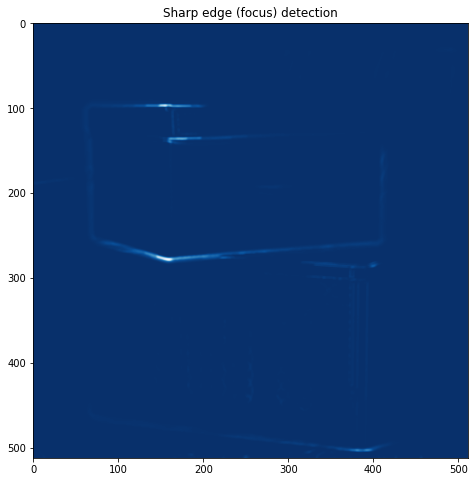

In [8]:
k_size = 3

def focus_measure(img):
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
    g_x = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize = k_size)
    g_y = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize = k_size)
    
    measure = (g_x**2 + g_y **2)**2
    kernel = np.ones((3,3))
    measure = cv2.filter2D(measure, -1, kernel)
    
    return measure
    
    
img = cv2.imread(os.path.join(ALIGNED_DATASET_dir, 'boxes','01.png'))
measure = focus_measure(img)
# cv2.imwrite('focus_sample.png', measure)
# sample = cv2.imread('focus_sample.png')
# plt.imshow(sample)
plt.figure(figsize=(8,8))
plt.title("Sharp edge (focus) detection")
plt.imshow(measure, cmap='Blues_r')

Not let's stack the resulted focus measures from the dataset and build the cost volumes.
Then get the bast label for each pixel.
Our initial depth map is consisting best labels for each pixel.

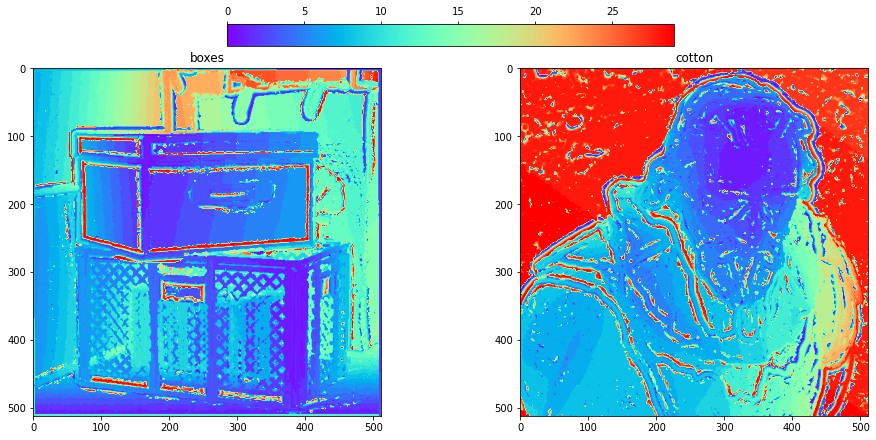

In [9]:
h, w, _ = img.shape
n_imgs = 30

all_imgs = {}
cost_volumes = {'boxes':np.zeros((h,w,n_imgs)), 'cotton':np.zeros((h,w,n_imgs))}
initial_depth_map = {}

fig, axs = plt.subplots(1,2, figsize=(16,8))
#fig.suptitle("Initial Depth Map")

for ax, dt_name in enumerate(['boxes','cotton']):
    
    all_imgs[dt_name] = []
    
    for i in range(0, 30):
        img = cv2.imread(os.path.join(ALIGNED_DATASET_dir, dt_name, "{:02d}.png".format(i+1)))
        all_imgs[dt_name].append(img)
        cost_volumes[dt_name][:,:,i] = focus_measure(img)
    
    initial_depth_map[dt_name] = np.argmax(cost_volumes[dt_name], axis = 2)

    im = axs[ax].imshow(initial_depth_map[dt_name], cmap='rainbow')
    axs[ax].set_title(dt_name)

fig.colorbar(im, ax=axs[:], shrink=0.5, location='top')
plt.show()

## Task 3: All-in-focus image (6pts)
---
From the initial depth map above, we can stitch focused parts of the images to make the all-in-focus image. 

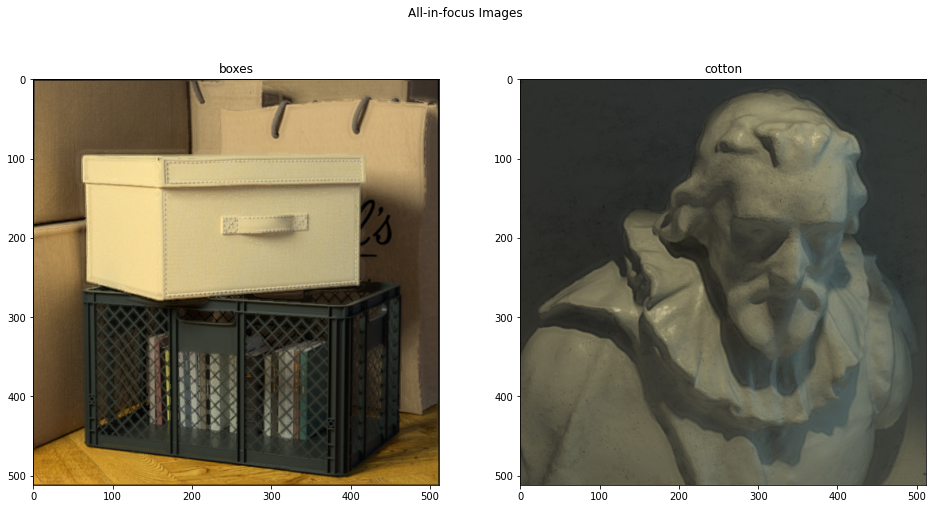

In [10]:
allInFocus_imgs = {'boxes':np.zeros((h,w,3)), 'cotton':np.zeros((h,w,3))}

fig, axs = plt.subplots(1,2, figsize=(16,8))
fig.suptitle("All-in-focus Images")

for ax, dt_name in enumerate(['boxes', 'cotton']):
    h, w = initial_depth_map[dt_name].shape
    for i in range(0,h):
        for j in range(0,w):
            best_idx = initial_depth_map[dt_name][i][j]
            allInFocus_imgs[dt_name][i,j,:] = all_imgs[dt_name][best_idx][i,j,:]
    
    cv2.imwrite(f"allInFocus_{dt_name}.png", allInFocus_imgs[dt_name])
    img = cv2.imread(f"allInFocus_{dt_name}.png", cv2.IMREAD_COLOR)
    axs[ax].imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    axs[ax].set_title(dt_name)

plt.show()

## Task 4: Graph-cuts (9pts) and weighted median filter (1pts)
---
We may use graph cut to get smoother depth map.
For graph cut, I used the python wrapper [github gco_python](https://github.com/amueller/gco_python) of the [multi-label graph optimization using alpha-beta swap algorithm](https://vision.cs.uwaterloo.ca/code/).
The library is a python wrapper for gco-v3.0 package. 

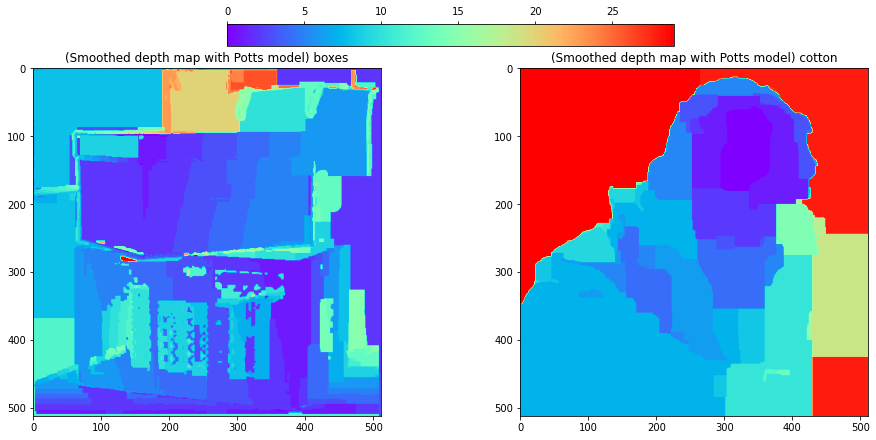

In [11]:
from gco_python.pygco import cut_simple

fig, axs = plt.subplots(1,2, figsize=(16,8))

results = {}
    
for ax, dt_name in enumerate(['boxes', 'cotton']):
    
    # Unaries
    Unaries_scale = 0.00001
    unaries = - cost_volumes[dt_name] * Unaries_scale
    unaries = unaries.astype(np.int32)

    # Potts model
    pair_potts = - 5 * np.eye(30, dtype=np.int32)
    pair_potts = pair_potts.astype(np.int32)
    results[dt_name] = cut_simple(unaries, unaries.shape[0] * pair_potts)
    
    cv2.imwrite(f"gco_potts_{dt_name}.png", results[dt_name])
    axs[ax].imshow(results[dt_name], cmap='rainbow')
    axs[ax].set_title(f"(Smoothed depth map with Potts model) {dt_name}")

    
fig.colorbar(im, ax=axs[:], shrink=0.5, location='top')
plt.show()

All-in-focus image by using smoothed depth map. The resulted images include less noise than the all-in-focus images generated by the initial depth map.

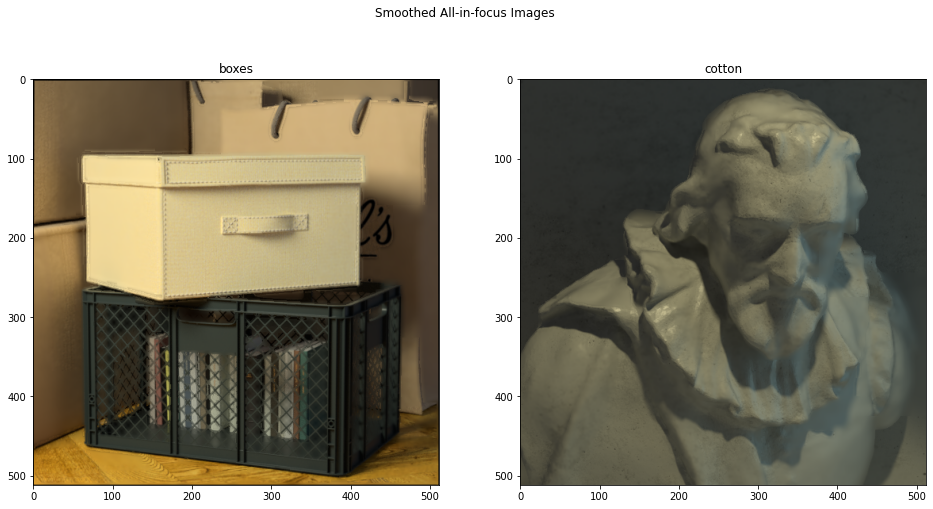

In [12]:
smoothed_allInFocus_imgs = {'boxes':np.zeros((h,w,3)), 'cotton':np.zeros((h,w,3))}

fig, axs = plt.subplots(1,2, figsize=(16,8))
fig.suptitle("Smoothed All-in-focus Images")

for ax, dt_name in enumerate(['boxes', 'cotton']):
    h, w = results[dt_name].shape
    for i in range(0,h):
        for j in range(0,w):
            best_idx = results[dt_name][i][j]
            smoothed_allInFocus_imgs[dt_name][i,j,:] = all_imgs[dt_name][best_idx][i,j,:]
    
    cv2.imwrite(f"allInFocus_smoothed_{dt_name}.png", smoothed_allInFocus_imgs[dt_name])
    img = cv2.imread(f"allInFocus_smoothed_{dt_name}.png", cv2.IMREAD_COLOR)
    axs[ax].imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    axs[ax].set_title(dt_name)

plt.show()

## REFERENCES
- https://sites.google.com/imagealignment/
- https://www.learnopencv.com/image-alignment-feature-based-using-opencv-c-python/
- https://vision.cs.uwaterloo.ca/code/
- https://github.com/amueller/gco_python